In [41]:
from torch.utils.data import DataLoader, random_split,TensorDataset
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import NN_classes
from torchvision import datasets, transforms
import training_methods
import DataLoading
import pivottablejs
%matplotlib inline

In [2]:
#executions = ["Network_Line_Out_N_101_N_102_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_101_N_105_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_102_N_106_cac1","Network_Line_Out_N_103_N_109_cac1"]
#executions = ["Network_Line_Out_N_101_N_102_cac1"]
#executions = ["Network_Full_Generation_Full","Network_Line_In_N_101_N_102_cac1","Network_Line_In_N_101_N_103_cac1","Network_Line_In_N_101_N_105_cac1"]

executions = ["Network_Existing_Generation_Full"]
sc = "sc01"
period = "2030"
folder = "Samples_3-bus_ACOPF"
te_s = 0.1
val_s = 0.2

In [3]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

Data/input_f_sc01_Network_Existing_Generation_Full_2030.csv
23


In [4]:
ts_in,ts_out =  DataLoading.split_tr_val_te(dfs_in,dfs_out,executions,te_s,val_s)

In [5]:
d_ft_in, d_ft_out = DataLoading.concat_and_normalize(ts_in,ts_out,executions)

In [6]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=32)
validation_loader = DataLoader(train,batch_size=32)

In [61]:
def create_model(nb_hidden,input_size,nb_neurons = (0,0)):
    if nb_hidden == 0: 
        m = NN_classes.ObjectiveEstimator_ANN_Single_layer(input_size=input_size,output_size=1)  
    elif nb_hidden == 1: 
        hs1 = int(sqrt(d_ft_in['train'].shape[1]))
        m = NN_classes.ObjectiveEstimator_ANN_1hidden_layer(input_size=input_size,hidden_size1=hs1,output_size=1)  
    elif nb_hidden == 2: 
        hs1 = int(sqrt(d_ft_in['train'].shape[1]))
        hs2 = int(sqrt(sqrt(d_ft_in['train'].shape[1])))
        m = NN_classes.ObjectiveEstimator_ANN_1hidden_layer(input_size=input_size,hidden_size1=hs1,hidden_size2=hs2,output_size=1)
    elif nb_hidden == 3:
        hs1 = int(d_ft_in['train'].shape[1]/4)
        hs2 = int(d_ft_in['train'].shape[1]/16)
        hs3 = int(d_ft_in['train'].shape[1]/64)
        m = NN_classes.ObjectiveEstimator_ANN_3hidden_layer(input_size=input_size,hidden_size1=hs1,hidden_size2=hs2,hidden_size3=hs3,output_size=1)
    return m

In [62]:
learning_rates = [0.01*4**i for i in range(4)]
loss_fn = torch.nn.MSELoss()
nbs_e = [4]#,4,8]
i=0
nbs_hidden = [0,3]
results = pd.DataFrame()
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            m = create_model(nb_hidden,input_size=d_ft_in['train'].shape[1])
            m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr"
            optimizer = torch.optim.Adam(m.parameters(), lr=lr)
            train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,True)
            
            saved_models = dict()
            
            for mt in ["min_val","all_epochs"]:
                path = f"trained_models/{mt}/model_{m_name}.pth"

                
                model = m
                m.load_state_dict(torch.load(path))
                m.eval()

                test_predictions = m(d_ft_in["test"].float())
                test_loss = loss_fn(test_predictions,d_ft_out["test"])
                
                train_predictions = m(d_ft_in["train"].float())
                train_loss = loss_fn(train_predictions,d_ft_out["train"])
                
                validation_prediction = m(d_ft_in["val"].float())
                validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                if mt == "min_val": 
                    min_val = True
                else: 
                    min_val = False

                r = pd.DataFrame({"Model_type": nb_hidden,"Min_val":min_val,"Epochs": nb_e,"Lr":lr, "Tr_l":train_loss.item(),"Te_l":test_loss.item(),"V_l": validation_loss.item()},index = [i]
                )
                i+=1
                results = pd.concat([results,r])

EPOCH 1:
  batch 1 loss: 0.0032111567258834837
  batch 101 loss: 0.012612657073186711


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.008557857948220643 valid 0.0020578145049512386
EPOCH 2:
  batch 1 loss: 2.2875850554555654e-05
  batch 101 loss: 0.0010681938388734124
LOSS train 0.000701104408122072 valid 0.0007910191197879612
EPOCH 3:
  batch 1 loss: 5.996021209284663e-06
  batch 101 loss: 0.0002559085060056532
LOSS train 0.00017174919970978588 valid 0.00045775194303132594
EPOCH 4:
  batch 1 loss: 3.2042386010289193e-06
  batch 101 loss: 8.284999760689971e-05
LOSS train 5.905812621893873e-05 valid 7.574815390398726e-05


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([874])) that is different to the input size (torch.Size([874, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6289])) that is different to the input size (torch.Size([6289, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1573])) that is different to the input size (torch.Size([1573, 1])). This will likely lead to incorrect results due to broadcasting. P

EPOCH 1:
  batch 1 loss: 7.598357001370459e-09
  batch 101 loss: 3.5267525583027036e-06
LOSS train 1.8042565276598634e-06 valid 1.8270878854309558e-07
EPOCH 2:
  batch 1 loss: 1.7451772293952671e-09
  batch 101 loss: 1.1701225131055537e-07
LOSS train 7.893608026330289e-08 valid 1.0667744732018036e-07
EPOCH 3:
  batch 1 loss: 9.498042174982402e-10
  batch 101 loss: 9.928076639464934e-08
LOSS train 6.448141113781532e-08 valid 4.4329382831165276e-08
EPOCH 4:
  batch 1 loss: 2.7932307133937684e-10
  batch 101 loss: 1.5157064648718687e-07
LOSS train 1.2346435350678596e-07 valid 5.392543656057569e-08
EPOCH 1:
  batch 1 loss: 0.0013920286297798158
  batch 101 loss: 0.011484130586068205
LOSS train 0.006969355547811445 valid 0.0008482186240144074
EPOCH 2:
  batch 1 loss: 5.344028468243778e-06
  batch 101 loss: 0.0004247836484319123
LOSS train 0.0005061481445912523 valid 0.0008557186811231077
EPOCH 3:
  batch 1 loss: 1.9671343034133315e-06
  batch 101 loss: 0.0011325031315573143
LOSS train 0.002

array([<Axes: title={'center': 'Te_l'}, xlabel='[Model_type, Min_val]'>,
       <Axes: >], dtype=object)

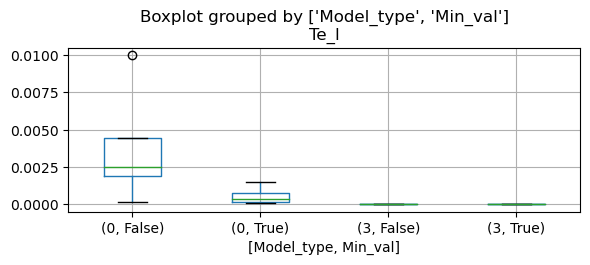

In [73]:
results.boxplot(column = ["Te_l"],by = ["Model_type","Min_val"],layout = (2,1),sharey = False)

In [35]:
pivottablejs.pivot_ui(results)